# Final project: Competition


    Hand-in bug-free (try "Kernel" > "Restart & Run All") and including all (textual as well as figural) output via Blackboard before the deadline (see Blackboard).
    
Learning goals:
1. Build your own state-of-the-art artificial neural network
1. Work on a real-world problem definition
1. Work in a machine learning competition framework

The final assignment is a neural network competition. Your task is to classify categories of clothing on the Fashion-MNIST data set, which has recently been proposed as a more challenging alternative to the standard MNIST dataset. For a more detailed description, some illustrations of the categories, reasons why Fashion-MNIST might be a better benchmark dataset than the classic MNIST dataset, and more, you can check [their GitHub](https://github.com/zalandoresearch/fashion-mnist). 

The competition is set up as an InClass competition [on Kaggle](https://www.kaggle.com/t/de281a20013a41a3ab724ec020848e23). If you want to continue following the machine learning direction, Kaggle is a great platform for training skills on real-world problems. Via our Kaggle InClass competition, you will be provided with a training and a validation dataset for your own (local) use, and with the features of the competition test set, for which you will generate predictions top be submitted to Kaggle. 

In this notebook, we provide a code basis which loads the dataset, trains a simple model, and writes the competition test set predictions into the file `test_set_predictions.csv`. This is the file you will create with your own model, and that you should submit to the competition website. 

The test dataset that we provide you with, contains approximately 42% of the actual total test data we have. The leaderboard will, during the competition, show the performance of your model on this 42% split. Please note, that the final results will be based on the other 58%. This means that overfitting the provided test dataset using the leaderboard will highly likely result in a poor performance on the final evaluation. This also means that the final standings may be different. The final evaluation will be performed after the deadline. 

Based on the final evaluation, the Top 6 project groups will earn the following bonus on their assignment grades (and eternal fame): 
1. **Top 1 and 2** will receive +1.0 on their overall assignment grade. 
1. **Top 3 and 4** will receive +0.5 on their overall assignment grade. 
1. **Top 5 and 6** will receive +0.3 on their overall assignment grade. 
*(Note that the maximum average assignment grade you can reach is 10)*

If you think that it is necessary you can implement and run your model in a normal Python script, however you need to paste the finalized code including the exercises in this notebook **inside this notebook**. Thus, this final assignment is nothing more than the other assignments: you submit a single notebook file to Blackboard before the deadline, and the assignment counts as the last assignment in the list of all assignments. 

### Exercise 1 (1 point)

1. **Create an account** for your group on Kaggle. Set your `Display Name` to your group number - using the format: `Group07`, `Group42`. You can also use your existing Kaggle account. Just temporarily change your `Display Name` to the group name. 

1. **Join our InClass competition** [on the Kaggle website](https://www.kaggle.com/t/de281a20013a41a3ab724ec020848e23). 

1. **Download the dataset** (python pickle) and the example submission from the 'data' tab at the competition webstite. 

1. After doing all the above, **submit the example submission** file `sampleSubmission.csv`. You do so by clicking 'Submit Predictions'. Here, you can upload the submission file, and also annotate it with versioning information or so.

You will receive the point for this exercise if we see your group name in the leaderboard. 

### Exercise 2 (1.5 points)

**Implement your neural network** within python 2.0 using the chainer library, just like all other assignments. Below, we have provided some preliminary code from which you can start. For instance, you could improve or use: 

* the neural network in the model class (obviously)
* the types of the [neural network layers](https://docs.chainer.org/en/stable/reference/links.html) (also check [this website to get some intuition](https://github.com/vdumoulin/conv_arithmetic))
* the objective function
* various types of preprocessing including [z-standardisation](http://scikit-learn.org/stable/modules/preprocessing.html) and data augmentation
* weight initialization
* prevention of overfitting via cross-validation
* batch normalization
* early stopping
* regularization hooks (L1, L2)
* dropout
* and much more

Most of these are small tricks that are easy to look up and add to your model. And most of them are implemented in state-of-the-art neural networks frameworks. Check [this page](http://lamda.nju.edu.cn/weixs/project/CNNTricks/CNNTricks.html) for a brief summary of many common tricks including  code. 

### Exercise 3 (1 point)

Make an informed choice for your `optimizer`. A good guide on various optimizers can be found [here](http://ruder.io/optimizing-gradient-descent/). Not all, but most of them are implemented in chainer. **Explain** why you have chosen this particular optimizer. 

### Exercise 4 (2 points)

**Explain** your neural network implementation in a structured way. Clearly motivate your choices. For instance, motivate the architecture (number and type of layers, number of units, non-linearities, extensions like dropout, etc.). 

### Exercise 5 (3.5 points)

**Evaluate** the performance of your model on the **local test set**. 

As a minimum, you should: 
1. Plot the training vs. test accurracy across training epochs and embed the resulting plot here. 
1. Plot some of the weights that your model has learned in the first layer.
1. Show 3 examples from the local test set that the model was unable to classify correctly.  (Check for which images real labels and predicted labels do not match. Plot the corresponding images.)
1. (Text question) Did your model perform well or not? Based on your observations, which architectural choices do you think have influenced performance most?

### Exercise 6 (1 point)

**Submit** `test_set_predictions.txt` to the [Kaggle competition website](https://www.kaggle.com/t/de281a20013a41a3ab724ec020848e23). You can submit the file twice a day to check your position in the leaderboard, and to improve your position. You will receive this point if we see a reasonable submission attempt online. 

### Code basis


#### Imports and dataset

Note, we have `train_features` and `train_labels` which you can use to train your model, `local_test_features` and `local_test_labels` which you can use to validate your model locally, and `kaggle_test_features`, which is the dataset for which you need to generate predictions and submit to the online Kaggle competition to obtain a performance for the leaderboard. 

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import chainer
import csv, pickle

from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
import chainer.datasets as D
from chainer.training import extensions

/Users/jordythielen/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


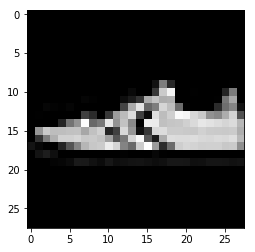

In [2]:
# Load the dataset
with open('competition_data.pkl', 'rb') as handle:
    competition_data = pickle.load(handle)

# Training data
train_features = competition_data['train_features'].astype('float32')
train_labels = competition_data['label_train'].astype('int8')

# Local test data
local_test_features = competition_data['local_test_features'].astype('float32')
local_test_labels = competition_data['local_test_labels'].astype('int8')

# Kaggle feature data
kaggle_test_features = competition_data['kaggle_test_features'].astype('float32')

# Show data example
plt.figure()
plt.imshow(train_features[123].reshape([28,28]), cmap='gray')

In [3]:
# Create chainer datasets
train = D.TupleDataset(train_features, train_labels)
test = D.TupleDataset(local_test_features, local_test_labels)

# Create chainer iterators
train_iter = iterators.SerialIterator(train, batch_size=100, shuffle=True)
test_iter = iterators.SerialIterator(test, batch_size=100, repeat=False, shuffle=False)

#### Model classes

Note, you do not necessarily need to use the templates as provided here. Use them as a starting point instead. Logistic regression can be framed as a neural network, which we provide below. Note that SVMs and decision trees are not allowed here. 

In [4]:
# Implement the neural network for your competition here:
class CompetitionNetwork(Chain):
    def __init__(self, n_out):
        pass

    def __call__(self, x):
        pass
    
# Linear regression model for testing the competition process:
class LinearRegression(Chain):
    def __init__(self, n_out):
        super(LinearRegression, self).__init__()
        with self.init_scope():
            self.lr = L.Linear(None, n_out)

    def __call__(self, x):
        y = self.lr(x)
        return y

# The classifier setup, including the objective/loss function
class Classifier(Chain):
    def __init__(self, predictor):
        super(Classifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor

    def __call__(self, x, t):
        y = self.predictor(x)
        loss = F.softmax_cross_entropy(y, t) # The objective function
        accuracy = F.accuracy(y, t)
        report({'loss': loss, 'accuracy': accuracy}, self)
        return loss
    
    def predict(self, x):  
        yclass = F.softmax( self.predictor(x) ).data.argmax(axis=1)
        return yclass

#### Set up optimizer and run training

In [5]:
# Setup model
model = Classifier(LinearRegression(n_out=10))   # replace this with CompetitionNetwork

# Setup optimizer
optimizer = optimizers.SGD(lr=0.1)
optimizer.setup(model)

# Setup trainer
updater = training.StandardUpdater(train_iter, optimizer)
trainer = training.Trainer(updater, (50, 'epoch'), out='competition_output')

# Add local validation set
trainer.extend(extensions.Evaluator(test_iter, model))

# Print/log results
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(["epoch", "main/accuracy", "validation/main/accuracy",  "main/loss", "validation/main/loss"]))

# Start training
trainer.run()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss
1           0.6618         0.726                     22073.3     30314                 
2           0.7167         0.653                     14780.7     22404.2               
3           0.728817       0.7848                    13559.4     7231.12               
4           0.734767       0.729                     13528.9     11921                 
5           0.738567       0.6214                    12849.1     18796.2               
6           0.744817       0.7578                    12075.7     9335.71               
7           0.744167       0.7198                    12345.4     15953.9               
8           0.747867       0.7474                    12015.6     11835.2               
9           0.7444         0.7644                    12528.8     8780.67               
10          0.7493         0.7534                    11926.1     7148.71               
11          0.7459         0.7446 

#### Predict on competition data set and write submission file

Note that the submission file is a simple CSV file which contains two columns: The item `ID` and the predicted `class` label. With the code below, you can transform the vector of predictions into the required submission file. Submit this CSV file manually to the competition website.

In [6]:
# Predict labels of the kaggle test dataset using the trained model
kaggle_test_predicted_labels = model.predict(kaggle_test_features)

In [7]:
# Write the submission file
f = open("kaggle_test_predicted_labels.csv", "w")
w = csv.writer(f, delimiter=',')
w.writerow(['ID','class'])
for item_id in xrange(kaggle_test_features.shape[0]):
    w.writerow([item_id, kaggle_test_predicted_labels[item_id]])
f.close()